# Kalman filter 1D

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

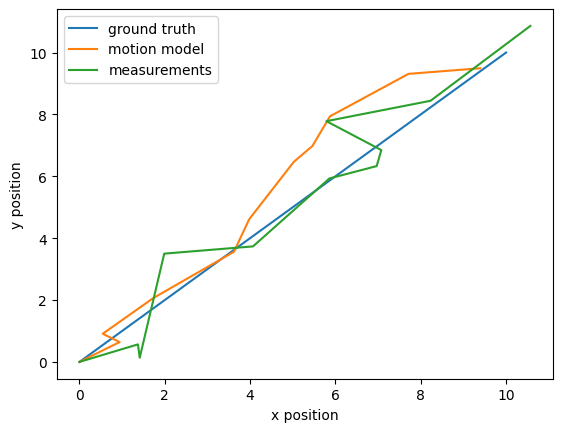

In [7]:
# init ground truth data
num_steps = 10
ground_truth_xs = np.linspace(0, 10, num = num_steps + 1) # [,, 1, ...., 10]
ground_truth_ys = ground_truth_xs.copy() # x = y
ground_truth_states = np.stack((ground_truth_xs, ground_truth_ys), axis=1) # [[0, 0], [1, 1], ...., [10, 10]]

# simulate motion
x_0, y_0 = 0, 0
motion_states = [np.array([x_0, y_0])]
u_t = np.array([1.0, 1.0])
A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]])
for _ in range(num_steps):
    motion_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=Q)
    new_state = A @ motion_states[-1] + B @ u_t + motion_noise
    motion_states.append(new_state)

# simulate measurement
measurement_states = [np.array([x_0, y_0])]
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.75, 0],
              [0, 0.75]])
for i in range(num_steps):
    measurement_noise = np.random.multivariate_normal(mean = np.array([0, 0]), cov=R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise
    measurement_states.append(new_measurement)

# plot and compare
motion_states = np.array(motion_states)
measurement_states = np.array(measurement_states)
plt.plot(ground_truth_states[:,0], ground_truth_states[:,1])
plt.plot(motion_states[:,0], motion_states[:,1])
plt.plot(measurement_states[:,0], measurement_states[:,1])
# plt.xlim(-1,12)
# plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements'])
# plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Implementation of Kalman filter

In [16]:
def predict(A, B, Q, u_t, mu_t, Sigma_t):
    predicted_mu = A @ mu_t + B @ u_t
    predicted_Sigma = A @ Sigma_t @ A.T + Q
    return predicted_mu, predicted_Sigma

In [17]:
def update(H, R, z, predicted_mu, predicted_Sigma):
    residual_mean = z - H @ predicted_mu
    residual_covariance = H @ predicted_Sigma @ H.T + R
    kalman_gain = predicted_Sigma @ H.T @ np.linalg.inv(residual_covariance)
    updated_mu = predicted_mu + kalman_gain @ residual_mean
    updated_Sigma = predicted_Sigma - kalman_gain @ H @ predicted_Sigma
    return updated_mu, updated_Sigma

In [25]:
# Re-initialize the problem with the given information
mu_0 = np.array([0, 0])
Sigma_0 = np.array([[0.1, 0],
                     [0, 0.1]])
u_t = np.array([1, 1]) # we assume constant control input

A = np.array([[1, 0],
              [0, 1]])
B = np.array([[1, 0],
              [0, 1]])
Q = np.array([[0.3, 0],
              [0, 0.3]])
H = np.array([[1, 0],
              [0, 1]])
R = np.array([[0.75, 0],
              [0, 0.6]])

# Initialize empty lists to store the filtered states and measurements for plotting
measurement_states = []
filtered_states = []

# Run KF for each time step
mu_current = mu_0.copy()
Sigma_current = Sigma_0.copy()
for i in range(num_steps):
    
    # Predict step
    predicted_mu, predicted_Sigma = predict(A, B, Q, u_t, mu_current, Sigma_current)
    
    # Get measurement (in real life, we get this from our sensor)    
    measurement_noise = np.random.multivariate_normal(mean=np.array([0,0]), cov=R) # ~N(0,R)
    new_measurement = H @ ground_truth_states[i+1] + measurement_noise # this is z_t
    
    # The rest of update step
    mu_current, Sigma_current = update(H, R, new_measurement, predicted_mu, predicted_Sigma)
    
    # Store measurements and mu_current so we can plot it later
    measurement_states.append(new_measurement)
    filtered_states.append(mu_current)

# For plotting purposes, convert the lists to array
measurement_states = np.array(measurement_states)
filtered_states = np.array(filtered_states) 

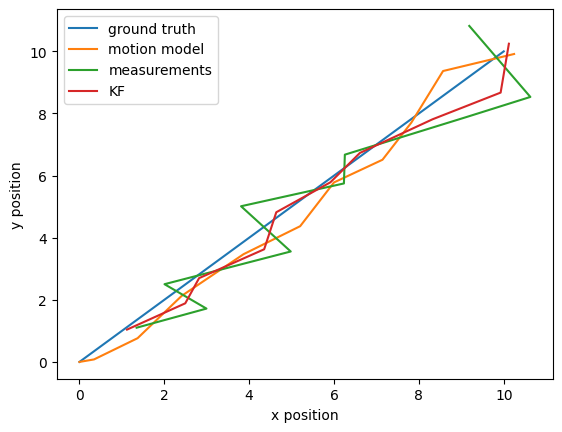

In [26]:
# Let's plot the results

plt.plot(ground_truth_states[:,0], ground_truth_states[:,1]) # from previous section
plt.plot(motion_states[:,0], motion_states[:,1]) # from previous section
plt.plot(measurement_states[:,0], measurement_states[:,1])
plt.plot(filtered_states[:,0], filtered_states[:,1])
# plt.xlim(-1,12)
# plt.ylim(-1,12)
plt.xlabel('x position')
plt.ylabel('y position')
plt.legend(['ground truth', 'motion model', 'measurements', 'KF'])
# plt.gca().set_aspect('equal', adjustable='box')
plt.show()